In [2]:
# 1. Load documents (e.g., medical PDFs)
from langchain.document_loaders import PyPDFLoader, DirectoryLoader

# 2. Split documents into smaller chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 3. Embed chunks using transformer models
from sentence_transformers import SentenceTransformer  # (used under the hood)
from langchain.embeddings import HuggingFaceEmbeddings

# 4. Set up vector store for storing and querying embeddings
import pinecone
from langchain.vectorstores import Pinecone

# 5. Load your LLM (for generating answers from retrieved docs)
from langchain.llms import CTransformers

# 6. Create prompt templates to instruct your LLM
from langchain.prompts import PromptTemplate

# 7. Chain everything using RetrievalQA (retriever + LLM)
from langchain.chains import RetrievalQA

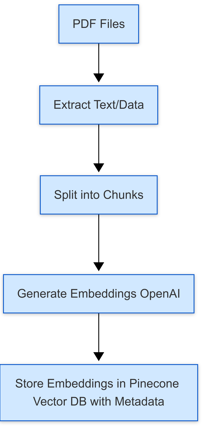

In [13]:
def load_pdf(data):

    loader = DirectoryLoader(data, glob="*.pdf" ,loader_cls=PyPDFLoader)       # Load all PDF files from a directory

    document=loader.load()           # here .load() is a method which will return a list of dictionaries, each dictionary contains the text of a pdf file
    return document

In [15]:
extracted_data = load_pdf("D:\chatbot2.0\data")    # Load all PDF files from a directory
#extracted_data

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\abhishek jyotiba\AppData\Local\Temp\ipykernel_31856\2874660418.py:1: SyntaxWarning: invalid escape sequence '\c'
  extracted_data = load_pdf("D:\chatbot2.0\data")    # Load all PDF files from a directory


In [16]:
def chunk_splitter(extracted_data):
    splitter = RecursiveCharacterTextSplitter(chunk_size=500 , chunk_overlap=50)  # Split the text into chunks of 500 characters with an overlap of 50 characters

    text_chunks = splitter.split_documents(extracted_data)  # here .split() is a method which will return a list of dictionaries, each dictionary contains the text of a chunk
    return text_chunks

In [17]:
chunks = chunk_splitter(extracted_data)
#chunks
print('No of chunks:', len(chunks))

No of chunks: 5961


In [3]:
def load_embedding_model():
    embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    return embedding

In [4]:
embeddings = load_embedding_model()

embeddings

C:\Users\abhishek jyotiba\AppData\Local\Temp\ipykernel_42644\291999263.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

In [ ]:
result_query = embeddings.embed_query("I Am Abhishek")
print('length of query',len(result_query))

length of query 384


**PINECONE VERSION - Version: 6.0.2**

STEPS:

1.INITIALIZE THE PINECONE \
2.CONNECT THE INDEX \
3.UPSERT THE VECTOR

In [ ]:
PINECONE_API_KEY ='pcsk_2U7yy5_HDTJQWg9WaRgBXi6crVgEk8tzF8oLtEhUeKeAr1rToQNfJk6kxEtiu4FrNnfxxx'

In [ ]:
from pinecone import Pinecone

pc = Pinecone(api_key=PINECONE_API_KEY)
print(pc.list_indexes())

In [7]:
index = pc.Index("chatbot2-test")

In [ ]:
def insert_vectors(chunks, batch_size=50):
    vectors = []

    for i, chunk in enumerate(chunks):
        embedding = embeddings.embed_query(chunk.page_content)  # 🔹 Generate embeddings for each chunk
        vectors.append({
            "id": str(i),
            "values": embedding,
            "metadata": {"text": chunk.page_content}  # Metadata for retrieval
        })

        # 🔹 Insert in Batches (Every `batch_size` chunks)
        if len(vectors) >= batch_size:
            index.upsert(vectors=vectors)  # Upsert batch
            print(f"Inserted {len(vectors)} vectors into Pinecone.")
            vectors = []  # Clear batch

    # 🔹 Insert any remaining vectors
    if vectors:
        index.upsert(vectors=vectors)
        print(f"Inserted {len(vectors)} remaining vectors into Pinecone.")

# Insert embeddings into Pinecone
insert_vectors(chunks, batch_size=50)# 🔹 Set batch size to 50

# **PHASE-2**
**Testing of query**

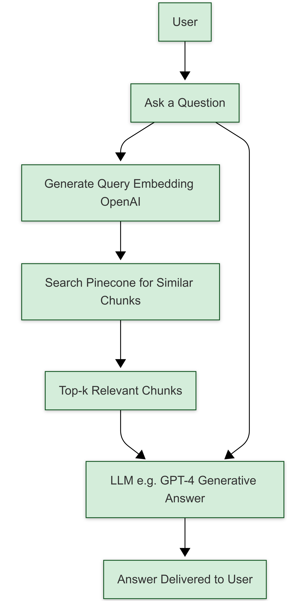

In [33]:
def search_pinecone(query, index, embedding_model, top_k=2):
    query_vector = embedding_model.embed_query(query)
    results = index.query(vector=query_vector, top_k=top_k, include_metadata=True)
    return results


In [ ]:
results = search_pinecone("What are the symptoms of diabetes?", index, embeddings)
for match in results["matches"]:
    print(match["metadata"]["text"])


In [35]:
contexts = [match['metadata']['text'] for match in results['matches']]
context_text = "\n\n".join(contexts)


In [38]:
prompt_template="""
Use this info to answer the question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: {context}
Question: {question}
"""

final_prompt = prompt_template.format(
    context=context_text,
    question="What are the symptoms of diabetes?"
)


In [40]:
from langchain.llms import CTransformers

llm = CTransformers(
    model="D:\\chatbot2.0\\models\\llama-2-7b-chat.ggmlv3.q4_0.bin",
    model_type="llama",
    config={
        "max_new_tokens": 200,
        "temperature": 0.7,
        "top_p": 0.95,
        "repetition_penalty": 1.1
    }
)

# Test it

print(llm(final_prompt))


Answer: The symptoms of diabetes can vary greatly depending on the type of diabetes and the individual affected. Some common symptoms include fatigue, high blood sugar levels (hyperglycemia), muscle weakness or cramping, difficulty climbing stairs, slowed or slurred speech, swallowing difficulties, and vision problems. It is important to diagnose diabetes as early as possible in order to prevent long-term damage to the body's organs.


In [41]:
!python -V
!pip list | grep langchain


Python 3.12.0


'grep' is not recognized as an internal or external command,
operable program or batch file.
